# **MCBS - Final Project** 
## Data pre-processing for Model 1

In [1]:
import sys 
sys.path.append('/usr/local/lib/python3.7/dist-packages')

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import io

from vis.utils import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from skimage import io
#import residual_network

import sys
import shutil
import os.path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

Using TensorFlow backend.


In [3]:
# if set True, executed code will overwrite existing directories
# containing data from pre-processing steps

OVERWRITE = True 

In [4]:
def create_directory(directory):
    """ Creates directory, remove existing version if OVERWRITE set to True """
    if os.path.exists(directory):
        if OVERWRITE:
            shutil.rmtree(directory)
            os.mkdir(directory)
    else:
        os.mkdir(directory)

In [5]:
# Metadata used in the pre-processing functions

classes_dictionary_org = {'BAS':0, 'EBO':1, 'EOS':2, 'KSC':3, 'LYA':4, 'LYT':5, 'MMZ':6, 'MOB':7, 'MON':8, 'MYB':9, 'MYO':10, 'NGB':11, 'NGS':12, 'PMB':13, 'PMO':14 }
classes_dictionary = {value: key for key, value in classes_dictionary_org.items()}

abbreviation_dict = { 'NGS':'Neutrophil (segmented)', 
                      'NGB':'Neutrophil (band)',
                      'EOS':'Eosinophil',
                      'BAS':'Basophil',
                      'MON':'Monocyte',
                      'LYT':'Lymphocyte (typical)',
                      'LYA':'Lymphocyte (atypical)',
                      'KSC':'Smudge Cell',
                      'MYO':'Myeloblast',
                      'PMO':'Promyelocyte',
                      'MYB':'Myelocyte',
                      'MMZ':'Metamyelocyte',
                      'MOB':'Monoblast',
                      'EBO':'Erythroblast',
                      'PMB':'Promyelocyte (bilobed)'}



In [6]:
base_path = "../data/aml"
orig_data_path  = f"{base_path}/AML-Cytomorphology" #TIFF files
data_path = f"{base_path}/png"       #PNG files
split_data_path = f"{base_path}/split" #split data

aug_level  = 10000 # desired number of images in each class
aug_data_path = f"{base_path}/split/train{aug_level}" #augmented training data

### **Convert original images to PNGs**

In [7]:
def tiff_to_png(filepath, new_filepath):
    """ Save a copy of TIFF to a PNG file """  
    img = utils.load_img(filepath)
    img = img[:,:,:3]
    io.imsave(new_filepath, img)
    
def convert_from_tiff(orig_dir, new_dir):
    """ Iterates subdirectories and saves TIFF files to PNGs"""
    
    create_directory(new_dir)

    for subdir, dirs, files in os.walk(orig_dir):
        if not dirs:
            print(f"Processing {subdir}.")
            new_subdir = os.path.join(new_dir, subdir.split("/")[-1])
            create_directory(new_subdir)

            for file in files:
                if file.endswith('.tiff'):
                    filename = file.split(".")[0]
                    filepath = os.path.join(subdir, file)
                    new_filepath = os.path.join(new_subdir, ".".join([filename, "png"]))
                    
                    #convert file
                    tiff_to_png(filepath, new_filepath)
                    

In [14]:
convert_from_tiff(orig_data_path, data_path)

Processing ../data/aml/AML-Cytomorphology/KSC.
Processing ../data/aml/AML-Cytomorphology/LYT.
Processing ../data/aml/AML-Cytomorphology/PMB.
Processing ../data/aml/AML-Cytomorphology/MOB.
Processing ../data/aml/AML-Cytomorphology/MMZ.
Processing ../data/aml/AML-Cytomorphology/EOS.
Processing ../data/aml/AML-Cytomorphology/MON.
Processing ../data/aml/AML-Cytomorphology/MYO.
Processing ../data/aml/AML-Cytomorphology/NGS.
Processing ../data/aml/AML-Cytomorphology/BAS.
Processing ../data/aml/AML-Cytomorphology/MYB.
Processing ../data/aml/AML-Cytomorphology/LYA.
Processing ../data/aml/AML-Cytomorphology/PMO.
Processing ../data/aml/AML-Cytomorphology/NGB.
Processing ../data/aml/AML-Cytomorphology/EBO.


### **Stratified split into train, test and validation sets**

In [16]:
!pip3 install split-folders

In [17]:
import splitfolders

create_directory(split_data_path)

for subdir in ['','train','test','val']:
    create_directory(os.path.join(split_data_path, subdir))

splitfolders.ratio(data_path, output=split_data_path, seed=1234, ratio=(.8,.1,.1)) 

Copying files: 18365 files [00:04, 3680.75 files/s]


In [8]:
def get_number_of_files(directory):
    """ Get file count from a directory"""
    return sum([len(files) for r, d, files in os.walk(directory)])

def augment_data(directory, new_directory, abbv = "IMG", num_files_goal = 10000):
    
    new_subdirectory = os.path.join(new_directory, directory.split("/")[-1])
    
    print(f"Processing {directory}, augmented data will be saved to {new_subdirectory}.")
    shutil.copytree(directory, new_subdirectory)
    
    datagen = ImageDataGenerator(rotation_range=359,
                                  width_shift_range=0.2,  
                                  height_shift_range=0.2,    
                                  shear_range=0.2,        
                                  zoom_range=0.2,        
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

    images = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    num_files = len(images)
    
    while get_number_of_files(new_subdirectory) < num_files_goal:
        num_files = get_number_of_files(new_subdirectory)
        
        while num_files < num_files_goal:
            file = random.choice(images)
            img = load_img(file)  
            x = img_to_array(img) 
            x = x.reshape((1, ) + x.shape)  
            i = 0

            # generate and save
            for batch in datagen.flow(x, batch_size = 1, 
                                        save_to_dir = new_subdirectory,  
                                        save_prefix =f'AUG_{abbv}',
                                        save_format ='png'):
                i += 1
                num_files += 1
                
                if i >= 10: 
                    break

    print(f"Number of files after augmentation: {get_number_of_files(new_subdirectory)}")

In [19]:
# data augmentation, goal: 10000 images in each class

ncores = os.cpu_count()

r = Parallel(n_jobs = ncores, backend = 'threading', verbose = 51, pre_dispatch = 'all')(
        delayed(augment_data)(f"{split_data_path}/train/{abbv}", aug_data_path, abbv, aug_level) 
        for abbv in abbreviation_dict
        )

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
Processing ../data/aml/split/train/NGS, augmented data will be saved to ../data/aml/split/train10000/NGS.
Processing ../data/aml/split/train/NGB, augmented data will be saved to ../data/aml/split/train10000/NGB.
Processing ../data/aml/split/train/EOS, augmented data will be saved to ../data/aml/split/train10000/EOS.
Processing ../data/aml/split/train/BAS, augmented data will be saved to ../data/aml/split/train10000/BAS.
Processing ../data/aml/split/train/MON, augmented data will be saved to ../data/aml/split/train10000/MON.
Processing ../data/aml/split/train/LYT, augmented data will be saved to ../data/aml/split/train10000/LYT.
Processing ../data/aml/split/train/LYA, augmented data will be saved to ../data/aml/split/train10000/LYA.
Processing ../data/aml/split/train/KSC, augmented data will be saved to ../data/aml/split/train10000/KSC.
Number of files after augmentation: 10009
Processing ../data/aml/split/t

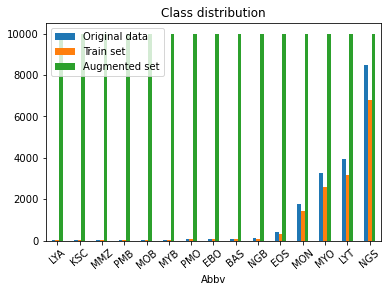

In [32]:
def get_number_of_files(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

data_dist = {}

for class_abbv, class_full in abbreviation_dict.items():
    data_dist[class_abbv] = [
                             class_full,
                             get_number_of_files(f'{orig_data_path}/{class_abbv}')
                             ,get_number_of_files(f'{split_data_path}/train/{class_abbv}')
                             ,get_number_of_files(f'{split_data_path}/train{aug_level}/{class_abbv}')
                            ]
    
data_dist_df = pd.DataFrame.from_dict(data_dist, 'index', columns=['Cell type','Original data', 'Train set', 'Augmented set'])
data_dist_df['%']= data_dist_df['Original data']/data_dist_df['Original data'].sum()
data_dist_df.sort_values(by = "%", inplace=True)
data_dist_df.index.name = "Abbv"
data_dist_df.reset_index(inplace=True)
data_dist_df.plot.bar(x= 'Abbv', y=['Original data', 'Train set', 'Augmented set'], title = "Class distribution")
plt.xticks(rotation=40)
plt.show()

In [31]:
#exact iamge counts per class
data_dist_df

,Abbv,Cell type,Original data,Train set,Augmented set,%
0,LYA,Lymphocyte (atypical),11,8,10000,0.000599
1,KSC,Smudge Cell,15,12,10000,0.000817
2,MMZ,Metamyelocyte,15,12,10000,0.000817
3,PMB,Promyelocyte (bilobed),18,14,10000,0.000980
4,MOB,Monoblast,26,20,10000,0.001416
5,MYB,Myelocyte,42,33,10000,0.002287
6,PMO,Promyelocyte,70,56,10000,0.003812
7,EBO,Erythroblast,78,62,10000,0.004247
8,BAS,Basophil,79,63,10000,0.004302
9,NGB,Neutrophil (band),109,87,10000,0.005935
